In [1]:
# basics
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from pathlib import Path

# for time analysis
import pytz
from datetime import datetime

# spatial analysis
import geopandas as gpd

# visualizations
from matplotlib import pyplot as plt

# 0. Prepare the paths, data, and more

In [2]:
class DataPrepare(object):
    
    project_path = r'D:\Projects\count_tweet'  # Specify a project directory
    shapefile_path = r'D:\Projects\Hong Kong Tweets Combined\shapefiles'  # Specify the path to city shapefile
    # Get all the punctuations\
    punctuations_all = string.punctuation + '。，﹑？！：；“”（）《》•……【】'
    
    def __init__(self, city_name, timezone, tweet_path, city_shapefile_name):
        """
        Prepare the city name, timezone, and path for the tweet data
        :param city_name: the name of a city
        :param timezone: the timezone of a city
        :param tweet_path: the path saving the tweet csv data
        """
        self.city_name = city_name
        self.timezone = timezone
        self.tweet_path = tweet_path
        self.city_shapefile_loc = os.path.join(DataPrepare.shapefile_path, city_shapefile_name)
        
    def __str__(self):
        """
        Print the basic information about the processed city
        """
        total_size = DataPrepare.filesize(self.get_size())
        string = 'city: {}\ntimezone: {}\ndata path: {}\ntotal size: {}\nshapefile: {}'.format(
            self.city_name, self.timezone, self.tweet_path, total_size, self.city_shapefile_loc)
        return string
    
    def get_size(self) -> int:
        """
        Get the size of all files in one directory in bytes
        """
        return sum(p.stat().st_size for p in Path(self.tweet_path).rglob('*'))
    
    def get_combined_tweets(self, return_geodata = False) -> pd.DataFrame:
        """
        Get the combined tweet dataframe
        """
        dataframe_list = []
        for file in os.listdir(self.tweet_path):
            dataframe = pd.read_csv(os.path.join(self.tweet_path, file), encoding='utf-8', index_col=0)
            dataframe_list.append(dataframe)
        concat_data = pd.concat(dataframe_list, axis=0).reset_index(drop = True)
        DataPrepare.data_overview(concat_data)
        return concat_data
    
    def find_tweet_in_city(self, dataframe):
        """
        Find the tweets posted in the city based on the 'lat' and 'lon' columns
        :param dataframe: a pandas dataframe saving the geocoded tweets
        :return: tweets posted in the city
        """
        if (dataframe['lat'].dtype.name != 'float64') or (dataframe['lon'].dtype.name != 'float64'):
            dataframe_copy = dataframe.copy()
            dataframe_copy['lat'] = dataframe_copy['lat'].astype(str)
            dataframe_copy['lon'] = dataframe_copy['lon'].astype(str)
            dataframe_copy_select = dataframe_copy[dataframe_copy['lat'].str.startswith(
                lat_lon_start_tuple)]
            dataframe_final = dataframe_copy_select[dataframe_copy_select['lon'].str.startswith(
                lat_lon_start_tuple)].copy()
            dataframe_final['lat'] = dataframe_final['lat'].astype(np.float64)
            dataframe_final['lon'] = dataframe_final['lon'].astype(np.float64)
        else:
            dataframe_final = dataframe.copy()
        geocoded_tweet_gdf = gpd.GeoDataFrame(dataframe_final,
                                              geometry=gpd.points_from_xy(dataframe_final.lon,
                                                                          dataframe_final.lat))
        geocoded_tweet_gdf = geocoded_tweet_gdf.set_crs(epsg=4326, inplace=True)
        city_shape = gpd.read_file(self.city_shapefile_loc)
        city_shape_4326 = city_shape.to_crs(epsg=4326)
        joined_data_final = DataPrepare.spatial_join(tweet_gdf=geocoded_tweet_gdf, shape_area=city_shape_4326)
        return joined_data_final.reset_index(drop=True)
    
    def get_city_shapefile(self):
        city_shape = gpd.read_file(self.city_shapefile_loc)
        return city_shape
    
    @staticmethod
    def get_geodataframe(tweet_dataframe):
        """
        Get the corresponding tweet geodataframe
        """
        geocoded_tweet_gdf = gpd.GeoDataFrame(
            tweet_dataframe, geometry=gpd.points_from_xy(
                tweet_dataframe.lon, tweet_dataframe.lat))
        return geocoded_tweet_gdf
    
    @staticmethod
    def filesize(size: int) -> str:
        for unit in ("B", "K", "M", "G"):
            if size < 1024:
                break
            size /= 1024
        return f"{size:.1f}{unit}"
    
    @staticmethod
    def data_overview(dataframe: pd.DataFrame):
        assert 'user_id_str' in dataframe, "The dataframe should contain user id column"
        assert 'id_str' in dataframe, "The dataframe should contain tweet id column"
        tweet_num = len(set(dataframe['id_str']))
        user_num = len(set(dataframe['user_id_str']))
        print('# of Users: {}; # of Tweets: {}'.format(user_num, tweet_num))
        
    @staticmethod
    def spatial_join(tweet_gdf, shape_area):
        """
        Find the tweets posted in one city's open space
        :param tweet_gdf: the geopandas dataframe saving the tweets
        :param shape_area: the shapefile of a studied area, such as city, open space, etc
        :return: tweets posted in open space
        """
        assert tweet_gdf.crs == shape_area.crs, 'The coordinate systems do not match!'
        joined_data = gpd.sjoin(left_df=tweet_gdf, right_df=shape_area, op='within')
        joined_data_final = joined_data.drop_duplicates(subset=['id_str'])
        return joined_data_final

In [3]:
HK_city = DataPrepare(city_name='Hong Kong', timezone=pytz.timezone('Asia/Shanghai'), 
                      tweet_path=os.path.join(DataPrepare.project_path, 'hk_tweets_2021'), 
                     city_shapefile_name='hk_tpu_project.shp')

In [4]:
print(HK_city)

city: Hong Kong
timezone: Asia/Shanghai
data path: D:\Projects\count_tweet\hk_tweets_2021
total size: 26.7M
shapefile: D:\Projects\Hong Kong Tweets Combined\shapefiles\hk_tpu_project.shp


In [5]:
# get some tweets posted in HK
HK_tweets = HK_city.get_combined_tweets()

# of Users: 5802; # of Tweets: 36666


# 1. Tweet filtering process

The tweet filtering process consists of the following steps:

1. Select the preferred language. In this case, we will only consider the English and Chinese. The language information can be seen from the ```lang``` column.
2. Get the geocoded tweets. The geocoded tweets have latitude and longitude informaiton, recorded in the ```lat``` and ```lon``` columns.
3. Only consider the tweets posted in a specific geographic boundary. In this case, we only consider the tweets posted in the Hong Kong
4. Remove the verified and bot accounts. The verified accounts, which are mostly run by organizations and celebrities, should be excluded in most urban studies. Whether one account is "verified" or not is shown in the ```verified``` column. Moreover, to remove the bot accounts, we use the following rules to delete the accounts:
    - whose number of tweets is 2 standard deviations away from the mean of the users from that city.
    - whose most identified geographic footprint (latitude & longitude pair) accounts for over 60% of all the footprints.

## 1.1 Select the tweets posted in English and Chinese

Please follow the [language code list](https://www.loc.gov/standards/iso639-2/php/code_list.php) to select the language type you want.

Here 'zh' represents Chinese and 'en' denotes English.

In [6]:
HK_tweets_en_zh = HK_tweets.loc[HK_tweets['lang'].isin(['en', 'zh'])]

In [7]:
DataPrepare.data_overview(HK_tweets_en_zh)

# of Users: 4458; # of Tweets: 20699


## 1.2 Get the Geocoded Tweets

In [8]:
HK_tweets_geocoded = HK_tweets_en_zh[~HK_tweets_en_zh['lat'].isna()]

In [9]:
DataPrepare.data_overview(HK_tweets_geocoded)

# of Users: 577; # of Tweets: 2198


In [10]:
HK_tweets_geocoded.sample(7)

,text,retweet_count,favorite_count,favorited,truncated,id_str,in_reply_to_screen_name,source,retweeted,created_at,...,place_type,full_name,place_name,place_id,place_lat,place_lon,lat,lon,expanded_url,url
14272,"Just posted a photo @ Central Plaza, Wan Chai,...",0,0,False,False,1432204247987363845,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Mon Aug 30 04:51:16 +0000 2021,...,NaN,"Wan Chai District, Hong Kong",Wan Chai District,01cb3bd54f92388e,22.271674,114.185178,22.279692,114.173765,https://www.instagram.com/p/CTL48oIhK3D/?utm_m...,https://t.co/15ed4m4g0I
23682,"I'm at TCL Eagle Lab in Shenzhen, Guangdong ht...",0,0,False,False,1433380511859290113,NaN,"<a href=""http://foursquare.com"" rel=""nofollow""...",False,Thu Sep 02 10:45:19 +0000 2021,...,NaN,"Guangdong, People's Republic of China",Guangdong,00059b04495a7e37,22.869936,113.419725,22.577279,113.922686,https://www.swarmapp.com/c/0J1s5dfWbT1,https://t.co/c4jpuNBDog
5304,"custom hot sale baseball jersey,no MOQ limit @...",0,0,False,False,1431083520689123332,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Fri Aug 27 02:37:54 +0000 2021,...,NaN,"广东, 中华人民共和国",广东,00059b04495a7e37,22.869936,113.419725,22.643476,114.177665,https://www.instagram.com/p/CTD7TRYFRIU/?utm_m...,https://t.co/qcsJcqyfbY
23448,My three princess.\nLove you always. #daughter...,0,0,False,False,1433359730202796035,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Thu Sep 02 09:22:44 +0000 2021,...,NaN,"Central & Western District, Hong Kong",Central & Western District,011a1d1e753ec5a8,22.276870,114.139883,22.282600,114.158000,https://www.instagram.com/p/CTUGZgwhxBf/?utm_m...,https://t.co/v1pw1fiA1Q
408,簡簡單單飲下茶 @ Regal Hongkong Hotel https://t.co/vK...,0,0,False,False,1430458988894855171,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Wed Aug 25 09:16:14 +0000 2021,...,NaN,"Wan Chai District, Hong Kong",Wan Chai District,01cb3bd54f92388e,22.271674,114.185178,22.279297,114.186937,https://www.instagram.com/p/CS_fS6ipX_uA9VQ-pN...,https://t.co/vKQow7oPZp
35669,"Good morning, #FreeIavanLam! :) #Sunrise 06:08...",0,0,False,False,1435001968804704256,NaN,"<a href=""http://enotty.dk/"" rel=""nofollow"">cip...",False,Mon Sep 06 22:08:25 +0000 2021,...,NaN,"Tsuen Wan District, Hong Kong",Tsuen Wan District,0118e53a43a7db78,22.365100,114.081927,22.396400,114.109500,NaN,NaN
16551,#samsmodel @panchox3 @ Sam's Tailor https://t....,0,0,False,False,1432458605865934849,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Mon Aug 30 21:42:00 +0000 2021,...,NaN,"Yau Tsim Mong District, Hong Kong",Yau Tsim Mong District,00dabde4090bf3b3,22.307350,114.168002,22.299278,114.172197,https://www.instagram.com/p/CTNsnS6hCk7/?utm_m...,https://t.co/56o8SxISR8


## 1.3 Only consider the tweets posted in HK

In [11]:
HK_tweets_in_HK = HK_city.find_tweet_in_city(dataframe=HK_tweets_geocoded)

In [12]:
DataPrepare.data_overview(HK_tweets_in_HK)

# of Users: 394; # of Tweets: 1373


Visualize the tweets and HK boundaries

In [13]:
HK_tweets_gdf = DataPrepare.get_geodataframe(HK_tweets_in_HK).set_crs(epsg=4326).to_crs(epsg=2326)

In [14]:
HK_tweets_gdf.crs

<Projected CRS: EPSG:2326>
Name: Hong Kong 1980 Grid System
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: China - Hong Kong - onshore and offshore.
- bounds: (113.76, 22.13, 114.51, 22.58)
Coordinate Operation:
- name: Hong Kong 1980 Grid
- method: Transverse Mercator
Datum: Hong Kong 1980
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [15]:
DataPrepare.data_overview(HK_tweets_gdf)

# of Users: 394; # of Tweets: 1373


In [16]:
HK_city_shape = HK_city.get_city_shapefile()

In [17]:
HK_city_shape.head()

,FID_1,merge_Nums,SmallTPU,Area,X,Y,geometry
0,0,1.0,121 & 122,5.096523e+05,834108.906504,816193.536025,"POLYGON ((833855.500 816730.490, 833852.070 81..."
1,1,2.0,123 & 124,1.093609e+06,834801.541761,815716.124658,"POLYGON ((834664.492 816415.378, 834710.125 81..."
2,2,3.0,146 & 147,6.480596e+05,837291.995943,815794.951399,"POLYGON ((837536.146 816437.751, 837536.631 81..."
3,3,4.0,156 & 158,6.711841e+06,839940.770162,814559.406871,"POLYGON ((839426.031 816282.149, 839426.091 81..."
4,4,5.0,164 & 165,2.235540e+06,842128.379729,813827.775535,"POLYGON ((841744.812 815060.750, 841752.000 81..."


In [18]:
HK_city_shape.crs

<Projected CRS: EPSG:2326>
Name: Hong Kong 1980 Grid System
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: China - Hong Kong - onshore and offshore.
- bounds: (113.76, 22.13, 114.51, 22.58)
Coordinate Operation:
- name: Hong Kong 1980 Grid
- method: Transverse Mercator
Datum: Hong Kong 1980
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Plot the geocoded tweets posted in Hong Kong

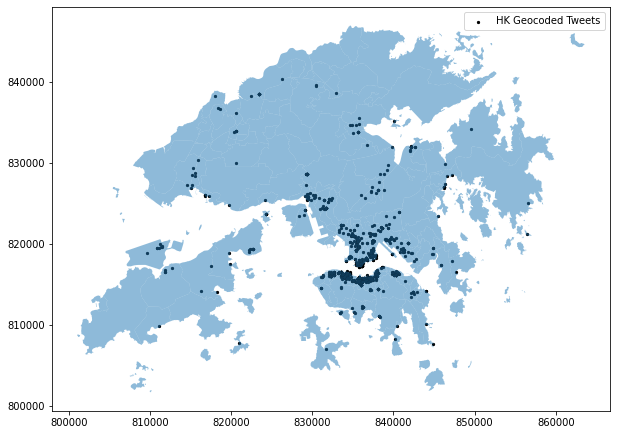

In [19]:
fig_hk_geo, axis_hk_geo = plt.subplots(1, 1, figsize=(10, 8))
HK_tweets_gdf.plot(ax=axis_hk_geo, color='black', markersize=5, label='HK Geocoded Tweets')
HK_city_shape.plot(ax=axis_hk_geo, alpha=0.5)
axis_hk_geo.legend()
plt.show()

## 1.4 Remove the verified and bot accounts

Firstly, we remove the verified accounts.

In [20]:
HK_tweets_without_verified = HK_tweets_gdf.loc[HK_tweets_gdf['verified'] == False]

In [21]:
DataPrepare.data_overview(HK_tweets_without_verified)

# of Users: 391; # of Tweets: 1366


Next, we remove the bot accounts

In [22]:
def count_user_tweet(dataframe: pd.DataFrame):
    """
    Count the users and the number of tweets they post.
    Bot accounts are likely to post many tweets in a long time
    :param dataframe: a tweet dataframe
    :return: a pandas dataframe saving the number of tweets posted by each user
    """
    user_set = set(dataframe['user_id_str'])
    user_list, tweet_count_list, tweet_pos_percent_list = [], [], []
    for user in user_set:
        data_select = dataframe.loc[dataframe['user_id_str'] == user].copy()
        if data_select.shape[0] > 0:
            user_list.append(user)
            data_select['pos'] = data_select.apply(lambda row: (row.lat, row.lon), axis=1)
            _, most_common_count = Counter(data_select['pos']).most_common()[0]
            tweet_count_list.append(data_select.shape[0])
            tweet_pos_percent_list.append(most_common_count / len(set(data_select['id_str'])))
    count_data = pd.DataFrame()
    count_data['user_id'] = user_list
    count_data['count'] = tweet_count_list
    count_data['loc_percent'] = tweet_pos_percent_list
    count_data_final = count_data.sort_values(by='count', ascending=False).reset_index(drop=True)
    return count_data_final

def get_bot_users(count_dataframe: pd.DataFrame, save_path: str, save_filename: str):
    """
    Get the user ids that are bot accounts. Some works for reference:
    https://www.mdpi.com/2078-2489/9/5/102/htm
    https://www.sciencedirect.com/science/article/pii/S0001457517302269
    :param count_dataframe: the pandas dataframe counting the tweet count and loc percent
    :param save_path: the path to the save the bot user ids
    :param save_filename: the name of the saved file
    :return: None. The bot ids are saved to the local directory
    """
    assert 'count' in count_dataframe, 'The count dataframe should have a column named count'
    assert 'loc_percent' in count_dataframe, 'The count dataframe should have a column named loc_percent'
    assert save_filename.endswith('.npy'), 'The saved filename should end with .npy'

    tweet_count_mean = np.mean(count_dataframe['count'])
    tweet_count_std = np.std(count_dataframe['count'])
    threshold = tweet_count_mean + 2 * tweet_count_std
    decision = (count_dataframe['count'] > threshold) & (count_dataframe['loc_percent'] > 0.6)
    bot_count_dataframe = count_dataframe[decision]
    bot_ids = np.array(list(set(bot_count_dataframe['user_id'])))
    print('We have got {} bots'.format(len(bot_ids)))
    print('They posted {} tweets'.format(sum(bot_count_dataframe['count'])))
    np.save(os.path.join(save_path, save_filename), bot_ids)

In [23]:
get_bot_users(count_user_tweet(HK_tweets_without_verified), save_path=os.getcwd(), save_filename='hk_bots.npy')

We have got 3 bots
They posted 71 tweets


Load the bot accounts...

In [24]:
bot_accounts = np.load('hk_bots.npy')
bot_accounts

array([          456413834,            17430060, 1229060688603013127],
      dtype=int64)